<table style="border: none" align="left">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>Use Keras experiment with HPO to predict handwritten digits</b></font></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="40" width="40"></th>
   </tr> 
   <tr style="border: none">
       <td style="border: none"><img src="https://github.com/pmservice/wml-sample-models/raw/master/tensorflow/hand-written-digit-recognition/images/experiment_banner.png" width="600" alt="Icon"></td>
   </tr>
</table>

This notebook contains steps and code to demonstrate support of deep learning experiments in Watson Machine Learning Service. This notebook introduces commands for getting data, training_definition persistance, experiment training, model persistance, model deployment and scoring.

Some familiarity with Python is helpful. This notebook uses Python 3 and <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/environments-parent.html" target="_blank" rel="noopener no referrer">Watson Studio environments.</a>


## Learning goals

In this notebook, you learn how to:

-  Work with Watson Machine Learning experiments to train Deep Learning models (Keras)
-  Save trained models in the Watson Machine Learning repository
-  Create an experiment
-  Deploy the trained model online and score


## Contents

1.	[Set up](#setup)
2.	[Create the training definitions](#definition)
3.	[Define the experiment](#experiment)
4.	[Run the experiment](#run)
5.  [Create the online deployment](#deploy)
6.	[Score data](#scoring)
7.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a <a href="https://console.ng.bluemix.net/catalog/services/machine-learning/" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance (a free plan is offered and information about how to create the instance is <a href="https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html" target="_blank" rel="noopener no referrer">here</a>).
-  Create a <a href="https://console.bluemix.net/catalog/services/cloud-object-storage" target="_blank" rel="noopener no referrer">Cloud Object Storage (COS)</a> instance (a lite plan is offered and information about how to order storage is <a href="https://console.bluemix.net/docs/services/cloud-object-storage/basics/order-storage.html#order-storage" target="_blank" rel="noopener no referrer">here</a>). <br/>**Note: When using Watson Studio, you already have a COS instance associated with the project you are running the notebook in.**
- Create new credentials with HMAC: 
    - Go to your COS dashboard.
    - In the **Service credentials** tab, click **New Credential+**.
    - Add the inline configuration parameter: {"HMAC":true}, click **Add**. (For more information, see <a href="https://console.bluemix.net/docs/services/cloud-object-storage/hmac/credentials.html#using-hmac-credentials" target="_blank" rel="noopener no referrer">HMAC</a>.)

    This configuration parameter adds the following section to the instance credentials, (for use later in this notebook):
    ```
      "cos_hmac_keys": {
            "access_key_id": "-------",
            "secret_access_key": "-------"
       }
    ```

### 1.1 Work with Cloud Object Storage (COS)

Install the boto library. This library allows Python developers to manage Cloud Object Storage (COS).

**Tip:** If `ibm_boto3` is not preinstalled in you environment, run the following command to install it: 

In [ ]:
# Run the command if ibm_boto3 is not installed.
!pip install ibm-cos-sdk --upgrade

In [2]:
import ibm_boto3
from ibm_botocore.client import Config
import os
import json
import warnings
import time

Enter your COS credentials in the following cell. 

You can find these credentials in your COS instance dashboard under the **Service credentials** tab.

**Note:** the HMAC key, described in [set up the environment](#setup) is included in these credentials.

In [ ]:
cos_credentials = {
  "apikey": "----",
  "cos_hmac_keys": {
    "access_key_id": "---",
    "secret_access_key": "---"
  },
  "endpoints": "https://cos-service.bluemix.net/endpoints",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:cloud-object-storage:global:a/bc6f89c9dbf0a21338f4ee6fa02cf6cf:d2901ba2-3196-4663-aee9-7ddfbb49eb7d::",
  "iam_apikey_name": "----",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "----",
  "resource_instance_id": "----"
}

# You need to save the apikey and resource_instance_id to create the COS resource object later.
api_key = cos_credentials['apikey']
service_instance_id = cos_credentials['resource_instance_id']

Define the endpoint.

To do this, go to the **Endpoint** tab in the COS instance's dashboard to get the endpoint information, then enter it in the cell below:

In [4]:
# Define endpoint information.
service_endpoint = 'https://s3-api.us-geo.objectstorage.softlayer.net'

You also need the IBM Cloud authorization endpoint to be able to create COS resource object.

In [5]:
# Define the authorization endpoint.
auth_endpoint = 'https://iam.bluemix.net/oidc/token'

Provide the type, endpoint_url and credentials to create the Boto resource.

In [6]:
# Create a COS resource.
cos = ibm_boto3.resource ('s3',
                         ibm_api_key_id=api_key,
                         ibm_service_instance_id=service_instance_id,
                         ibm_auth_endpoint=auth_endpoint,
                         config=Config(signature_version='oauth'),
                         endpoint_url=service_endpoint)

Create two buckets, which you will use to store training data and training results.

**Note:** The bucket names must be unique.

In [7]:
# Create buckets.
buckets = ['mnist-keras-data-example-1', 'mnist-keras-results-example-1']
for bucket in buckets:
    if not cos.Bucket(bucket) in cos.buckets.all():
        print('Creating bucket "{}"...'.format(bucket))
        try:
            cos.create_bucket(Bucket=bucket)
        except ibm_boto3.exceptions.ibm_botocore.client.ClientError as e:
            print('Error: {}.'.format(e.response['Error']['Message']))

Creating bucket "mnist-keras-data-example-1"...
Creating bucket "mnist-keras-results-example-1"...


Now you should have these 2 buckets.

In [ ]:
# Run this cell to display all buckets.
print(list(cos.buckets.all()))

### 1.2 Download the MNIST data and upload it to the COS buckets

You will work with the Keras **MNIST** sample dataset. Download your training data and upload them to the 'mnist-keras-data' bucket.

Run the code in the cell below to create 'MNIST_KERAS_DATA' folder and download the file from the link.

**Tip:** First, install the ``wget`` library with this command:
`!pip install wget`

In [8]:
!pip install wget --upgrade
link = 'https://s3.amazonaws.com/img-datasets/mnist.npz'

  Running setup.py bdist_wheel for wget ... done
  Stored in directory: /home/dsxuser/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [9]:
import wget, os

data_dir = 'MNIST_KERAS_DATA'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

if not os.path.isfile(os.path.join(data_dir, os.path.join(link.split('/')[-1]))):
    wget.download(link, out=data_dir)  
        
!ls MNIST_KERAS_DATA

mnist.npz


Upload the data files to the created buckets.

In [10]:
# Upload files to the buckets.
bucket_name = buckets[0]
bucket_obj = cos.Bucket(bucket_name)

for filename in os.listdir(data_dir):
    with open(os.path.join(data_dir, filename), 'rb') as data: 
        bucket_obj.upload_file(os.path.join(data_dir, filename), filename)
        print('{} is uploaded.'.format(filename))

mnist.npz is uploaded.


Have a look at the list of the created buckets and their contents.

In [11]:
# Display a list of buckets.
for obj in bucket_obj.objects.all():
    print('Object key: {}'.format(obj.key))
    print('Object size (kb): {}'.format(obj.size/1024))

Object key: mnist.npz
Object size (kb): 11221.126953125


You are done with Cloud Object Storage, and you are ready to train your model!

### 1.3 Work with the WML instance

Import the libraries you need to work with your WML instance.

In [12]:
# Import the libraries.
import urllib3, requests, json, base64, time, os
warnings.filterwarnings('ignore')

Authenticate to the Watson Machine Learning service on IBM Cloud.

**Tip**: Authentication information (your credentials) can be found in the <a href="https://console.bluemix.net/docs/services/service_credentials.html#service_credentials" target="_blank" rel="noopener no referrer">Service credentials</a> tab of the service instance that you created on IBM Cloud. <BR>If you cannot see the **instance_id** field in **Service Credentials**, click **New credential (+)** to generate new authentication information. 

**Action**: Enter your WML service instance credentials here.

In [ ]:
wml_credentials = {
  "url": "https://ibm-watson-ml.mybluemix.net",
  "username": "---",
  "password": "---",
  "instance_id": "---"
}

#### Install the `watson-machine-learning-client` from pypi

!pip install --upgrade watson-machine-learning-client

In [14]:
!rm -rf $PIP_BUILD/watson-machine-learning-client

In [ ]:
!pip install --upgrade watson-machine-learning-client

#### Import `watson-machine-learning-client` and authenticate to the service instance.

In [ ]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

In [17]:
client = WatsonMachineLearningAPIClient(wml_credentials)

In [18]:
# Display the client version number.
print(client.version)

1.0.302


**Note:** `watson-machine-learning-client` documentation can be found <a href="http://wml-api-pyclient.mybluemix.net/" target="_blank" rel="noopener no referrer">here</a>.

<a id="definition"></a>
## 2. Create the training definitions

For purpose of this example, two Keras model definitions have been prepared:
* Multilayer Perceptron (MLP)
* Convolution Neural Network (CNN)

In this section, you learn how to:

- [2.1 Prepare the training definition metadata](#prep)
- [2.2 Get the sample model definition content files from Git](#get)
- [2.3 Store the training definition in the WML repository](#store)

### 2.1 Prepare the training definition metadata<a id="prep"></a>

In [19]:
model_definition_1_metadata = {
            client.repository.DefinitionMetaNames.NAME: "MNIST-MLP",
            client.repository.DefinitionMetaNames.FRAMEWORK_NAME: "tensorflow",
            client.repository.DefinitionMetaNames.FRAMEWORK_VERSION: "1.5",
            client.repository.DefinitionMetaNames.RUNTIME_NAME: "python",
            client.repository.DefinitionMetaNames.RUNTIME_VERSION: "3.5",
            client.repository.DefinitionMetaNames.EXECUTION_COMMAND: "python3 mnist_mlp.py"
            }

In [20]:
model_definition_2_metadata = {
            client.repository.DefinitionMetaNames.NAME: "MNIST-CNN",
            client.repository.DefinitionMetaNames.FRAMEWORK_NAME: "tensorflow",
            client.repository.DefinitionMetaNames.FRAMEWORK_VERSION: "1.5",
            client.repository.DefinitionMetaNames.RUNTIME_NAME: "python",
            client.repository.DefinitionMetaNames.RUNTIME_VERSION: "3.5",
            client.repository.DefinitionMetaNames.EXECUTION_COMMAND: "python3 mnist_cnn.py"
            }

### 2.2 Get the sample model definition content file from Git (python scripts with CNN and MLP)<a id="get"></a> 

In [21]:
!rm -rf MNIST.zip

In [22]:
filename_mnist = 'MNIST.zip'

if os.path.isfile(filename_mnist):
    !ls 'MNIST.zip'
else:
    !wget https://github.com/pmservice/wml-sample-models/raw/master/keras/mnist/MNIST.zip
    !ls 'MNIST.zip'

--2018-08-22 12:49:45--  https://github.com/pmservice/wml-sample-models/raw/master/keras/mnist/MNIST.zip
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pmservice/wml-sample-models/master/keras/mnist/MNIST.zip [following]
--2018-08-22 12:49:45--  https://raw.githubusercontent.com/pmservice/wml-sample-models/master/keras/mnist/MNIST.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3836 (3.7K) [application/zip]
Saving to: ‘MNIST.zip’

100%[======================================>] 3,836       --.-K/s   in 0s      

2018-08-22 12:49:45 (58.8 MB/s) - ‘MNIST.zip’ saved [3836/3836]

MNIST.zip


### 2.3 Store the training definition in the WML repository<a id="store"></a>

##### Store definition 1

In [23]:
definition_1_details = client.repository.store_definition(filename_mnist, model_definition_1_metadata)

definition_1_url = client.repository.get_definition_url(definition_1_details)
definition_1_uid = client.repository.get_definition_uid(definition_1_details)
print(definition_1_url)

https://us-south.ml.cloud.ibm.com/v3/ml_assets/training_definitions/544dd463-947c-42e3-9955-eddf081d7d39


##### Store definition 2

In [24]:
definition_2_details = client.repository.store_definition(filename_mnist, model_definition_2_metadata)

definition_2_url = client.repository.get_definition_url(definition_2_details)
definition_2_uid = client.repository.get_definition_uid(definition_2_details)
print(definition_2_url)

https://us-south.ml.cloud.ibm.com/v3/ml_assets/training_definitions/ad413e45-e756-4c2d-815e-aa7e85509018


#### Display a list of the stored definitions.

In [25]:
client.repository.list_definitions()

------------------------------------  ---------  ------------------------  ----------
GUID                                  NAME       CREATED                   FRAMEWORK
ad413e45-e756-4c2d-815e-aa7e85509018  MNIST-CNN  2018-08-22T12:49:54.344Z  tensorflow
544dd463-947c-42e3-9955-eddf081d7d39  MNIST-MLP  2018-08-22T12:49:50.218Z  tensorflow
------------------------------------  ---------  ------------------------  ----------


<a id="experiment"></a>
## 3. Define the experiment 

In this section, you will learn how to:
- [4.1 Get the list of supported configuration parameters](#exlist)
- [4.2 Configure the experiment](#exconf)
- [4.3 Store the experiment in the WML repository](#exstore)

### 3.1 Get a list of the supported configuration parameters <a id="exlist"></a>

In [26]:
client.repository.ExperimentMetaNames.show()

--------------------------  ----  --------
META_PROP NAME              TYPE  REQUIRED
NAME                        str   Y
DESCRIPTION                 str   N
TAGS                        list  N
AUTHOR_NAME                 str   N
EVALUATION_METHOD           str   N
EVALUATION_METRICS          list  N
TRAINING_REFERENCES         list  Y
TRAINING_DATA_REFERENCE     dict  Y
TRAINING_RESULTS_REFERENCE  dict  Y
--------------------------  ----  --------


### 3.2 Configure the experiment<a id="exconf"></a>
Create an experiment that will train models based on previously stored definitions.

`TRAINING_DATA_REFERENCE` - location of training data

In [27]:
TRAINING_DATA_REFERENCE = {
                            "connection": {
                                "endpoint_url": service_endpoint,
                                "access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
                                "secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
                            },
                            "source": {
                                "bucket": buckets[0],
                            },
                            "type": "s3"
}

`TRAINING_RESULTS_REFERENCE` - location of training results.

In [28]:
TRAINING_RESULTS_REFERENCE = {
                                "connection": {
                                    "endpoint_url": service_endpoint,
                                    "access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
                                    "secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
                                },
                                "target": {
                                    "bucket": buckets[1],
                                },
                                "type": "s3"
}

Configure the hyper parameters optimizer for your experiment. You are interested in the `val_acc` metric so you define it as the optimizer `objective`. `num_optimizer_steps` tells the optimizer how many models you want to train based on the combination of hyper parameters values.

In [29]:
HPO = {
        "method": {
            "name": "rbfopt",
            "parameters": [
                client.experiments.HPOMethodParam("objective", "val_acc"),
                client.experiments.HPOMethodParam("maximize_or_minimize", "maximize"),
                client.experiments.HPOMethodParam("num_optimizer_steps", 3)
            ]
        },
        "hyper_parameters": [
            client.experiments.HPOParameter('learning_rate', min=0.0001, max=0.001, step=0.0003)
        ]
     }           

Configure your experiment. `TRAINING_REFERENCES` links previously stored training definitions and provides information about the `compute_configuration` that will be used to run the training.

In [30]:
experiment_metadata = {
            client.repository.ExperimentMetaNames.NAME: "MNIST experiment",
            client.repository.ExperimentMetaNames.DESCRIPTION: "Best model for MNIST.",
            client.repository.ExperimentMetaNames.EVALUATION_METHOD: "multiclass",
            client.repository.ExperimentMetaNames.EVALUATION_METRICS: ["val_acc"],
            client.repository.ExperimentMetaNames.TRAINING_DATA_REFERENCE: TRAINING_DATA_REFERENCE,
            client.repository.ExperimentMetaNames.TRAINING_RESULTS_REFERENCE: TRAINING_RESULTS_REFERENCE,
            client.repository.ExperimentMetaNames.TRAINING_REFERENCES: [
                        {
                            "name": "MNIST_MLP",
                            "training_definition_url": definition_1_url,
                            "compute_configuration": {"name": "k80x2"},
                            "hyper_parameters_optimization": HPO
                            
                        },
                        {
                            "name": "MNIST_CNN",
                            "training_definition_url": definition_2_url,
                            "compute_configuration": {"name": "k80x2"},
                        }],
            }

### 3.3 Store the experiment in the WML repository<a Id="exstore"></a>

In [31]:
# Store the experiment, and display the experiments uid.
experiment_details = client.repository.store_experiment(meta_props=experiment_metadata)

experiment_uid = client.repository.get_experiment_uid(experiment_details)
print(experiment_uid)

9d9b2c54-e180-4247-9c87-5cbb14b9cb68


#### Display a list of the stored experiments.

In [32]:
client.repository.list_experiments()

------------------------------------  ----------------  ------------------------
GUID                                  NAME              CREATED
9d9b2c54-e180-4247-9c87-5cbb14b9cb68  MNIST experiment  2018-08-22T12:50:23.683Z
------------------------------------  ----------------  ------------------------


#### Update the experiment.

You can update the experiment definition by running the code in the following cell.

In [33]:
updated_experiment_details = client.repository.update_experiment(experiment_uid, experiment_metadata)

#### Display the experiment definition details.

In [34]:
details = client.repository.get_experiment_details(experiment_uid)

#### Delete the experiment definition from the repository.

In [ ]:
client.repository.delete(experiment_uid)

<a id="run"></a>
## 4. Run the experiment

In this section, you will learn how to:
- [4.1 Start the experiment run](#exstart)
- [4.2 Monitor the experiment run](#exmon)
- [4.3 Access the metrics data](#exaccess)


### 4.1 Start the experiment run<a id="exstart"></a>

**Tip:** To run the experiment in background set optional parameter `asynchronous=True` (or remove it)

In [35]:
# Start the experiment run.
experiment_run_details = client.experiments.run(experiment_uid, asynchronous=True)

As you can see, the experiment run has been triggered.

#### Display the experiment run UID.

In [36]:
experiment_run_uid = client.experiments.get_run_uid(experiment_run_details)
print(experiment_run_uid)

330be28c-82c5-48a1-8ce5-12d348fb2303


#### List the runs for all experiments.
You can list experiment run using `client.experiments.list_runs()` method.

In [37]:
client.experiments.list_runs()

------------------------------------  ------------------------------------  -----------------  -------  --------------------
GUID (experiment)                     GUID (run)                            NAME (experiment)  STATE    CREATED
9d9b2c54-e180-4247-9c87-5cbb14b9cb68  330be28c-82c5-48a1-8ce5-12d348fb2303  MNIST experiment   pending  2018-08-22T12:51:31Z
------------------------------------  ------------------------------------  -----------------  -------  --------------------


#### List the training runs triggered by the experiment run.

**Hint:** Run the cell below several times during the run to see updates.

In [38]:
client.experiments.list_training_runs(experiment_run_uid)

------------------  ---------  -------  --------------------  --------  -----------
GUID (training)     NAME       STATE    SUBMITTED             FINISHED  PERFORMANCE
training-MKava-tig  MNIST_CNN  pending  2018-08-22T12:51:34Z  -         -
training-avaD--pig  MNIST_MLP  pending  2018-08-22T12:51:34Z  -         -
------------------  ---------  -------  --------------------  --------  -----------


#### Get information about the experiment run.
Use the following method to get details about a specific experiment run.

In [39]:
experiment_run_details = client.experiments.get_run_details(experiment_run_uid)

#### Check the status of the experiment run.
You can check experiment run status by calling `client.experiments.get_status(run_uid)` method. This is useful when you run an experiment in background.

In [40]:
client.experiments.get_status(experiment_run_uid)

{'best_results': {'experiment_best_model': {'training_guid': 'training-MKava-tig',
   'training_reference_name': 'MNIST_CNN',
   'training_url': 'https://us-south.ml.cloud.ibm.com/v3/ml_assets/training_definitions/ad413e45-e756-4c2d-815e-aa7e85509018'},
  'training_reference_best_model': [{'training_guid': 'training-MKava-tig',
    'training_reference_name': 'MNIST_CNN',
    'training_url': 'https://us-south.ml.cloud.ibm.com/v3/ml_assets/training_definitions/ad413e45-e756-4c2d-815e-aa7e85509018'},
   {'training_guid': 'training-avaD--pig_1',
    'training_reference_name': 'MNIST_MLP',
    'training_url': 'https://us-south.ml.cloud.ibm.com/v3/ml_assets/training_definitions/544dd463-947c-42e3-9955-eddf081d7d39'}]},
 'current_at': '2018-08-22T12:51:31Z',
 'current_iteration': 1,
 'state': 'completed',
 'submitted_at': '2018-08-22T12:51:31Z'}

#### View all the available information about the experiment.
Use the following method to get all information about particular experiment.

In [41]:
experiment_details = client.experiments.get_details(experiment_uid)

Use the print command to display experiment details (change the cell type to code, then run the cell).

In [ ]:
print(json.dumps(experiment_details, indent=2))

#### List the training runs uids.

The training run uid can be used to monitor a selected training within an experiment.

In [42]:
experiment_run_details = client.experiments.get_run_details(experiment_run_uid)
training_run_uids = client.experiments.get_training_uids(experiment_run_details)

for i in training_run_uids:
    print(i)

training-MKava-tig
training-avaD--pig
training-avaD--pig_0
training-avaD--pig_1
training-avaD--pig_2


#### Delete an experiment run.

Run the code in the next cell to an delete experiment run and results. The code is commented out here, because you do not want to delete any experiement runs that you will use later in this notebook .

**Tip:** the `delete` method can be also used to terminate experiment run.

In [ ]:
client.experiments.delete(experiment_run_id)

### 4.2 Monitor the experiment run<a id="exmon"></a>
You can monitor experiment run by calling `client.experiments.monitor_logs(run_uid)`. This method streams content from the training logs to the console.

**Tip:** You can also monitor a particular training run by calling `client.training.monitor_logs(training_run_uid)`.
To get the training_run_uid you can call the method `client.experiments.list_training_runs(experiment_run_uid)`

In [43]:
client.experiments.monitor_logs(experiment_run_uid)



########################################################################

Monitor started for experiment run: 330be28c-82c5-48a1-8ce5-12d348fb2303

########################################################################




--------------------------------------------------------
Log monitor started for training run: training-MKava-tig
--------------------------------------------------------




--------------------------------------------------------
Log monitor started for training run: training-avaD--pig
--------------------------------------------------------




-----------------
Log monitor done.
-----------------




**Note:** Before moving on to next section, make sure that your experiment run has completed.

In [44]:
client.experiments.get_status(experiment_run_uid)['state']

'completed'

### 4.3 Access the metrics data<a id="exaccess"></a>

Run the code in the following cell to get the **final** evaluation metrics.

In [45]:
metrics = client.experiments.get_latest_metrics(experiment_run_uid)

Run the code in the following cell to get the **all** evaluation metrics.

In [46]:
all_metrics = client.experiments.get_metrics(experiment_run_uid)

#### Use plotly to visualize the training results.

In [ ]:
!pip install cufflinks --upgrade

In [48]:
import sys
import pandas
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import plotly.graph_objs as go

init_notebook_mode(connected=True)
sys.path.append("".join([os.environ["HOME"]])) 

Put your final metrics data into a pandas dataframe.

In [49]:
import pandas as pd

metrics_df = pd.DataFrame(columns=['GUID', 'NAME', 'METRIC NAME', 'METRIC VALUE'])

for m in metrics:
    for v in m['metrics']['values']:
            metrics_df = metrics_df.append({'GUID': m['training_guid'], 'NAME': m['training_reference_name'], 'METRIC NAME': v['name'], 'METRIC VALUE': v['value']}, ignore_index=True)
    
metrics_df

,GUID,NAME,METRIC NAME,METRIC VALUE
0,training-MKava-tig,MNIST_CNN,acc,0.985983
1,training-MKava-tig,MNIST_CNN,loss,0.047398
2,training-MKava-tig,MNIST_CNN,val_acc,0.988800
3,training-MKava-tig,MNIST_CNN,val_loss,0.032573
4,training-avaD--pig_0,MNIST_MLP,val_acc,0.961000
5,training-avaD--pig_0,MNIST_MLP,val_loss,0.123725
6,training-avaD--pig_1,MNIST_MLP,val_acc,0.979400
7,training-avaD--pig_1,MNIST_MLP,val_loss,0.078787
8,training-avaD--pig_2,MNIST_MLP,val_acc,0.978100
9,training-avaD--pig_2,MNIST_MLP,val_loss,0.071971


Visualize the metrics data using a grouped bar chart.

In [50]:
data = []

for i in list(pd.unique(metrics_df['METRIC NAME'])):
    data.append(go.Bar(x=metrics_df[metrics_df['METRIC NAME'].isin([i])]['GUID'] + ' (' + metrics_df[metrics_df['METRIC NAME'].isin([i])]['NAME'] + ')', y=metrics_df[metrics_df['METRIC NAME'].isin([i])]['METRIC VALUE'], name=i))


layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

## 5. Create the online deployment<a id="deploy"></a>

You can deploy the stored model as a web service (online) by running the code in the following cells.

In this section, you will learn how to:
- [5.1 Save the model](#savemod)
- [5.2 Deploy the model](#createdep)

### 5.1 Save the model <a id="savemod"></a>

#### Call this method to save the model in the WML repository.

In [51]:
status = client.experiments.get_status(experiment_run_uid)
best_model_uid = status['best_results']['experiment_best_model']['training_guid']
best_model_name = status['best_results']['experiment_best_model']['training_reference_name']

print(best_model_uid + ' (' +  best_model_name  + ')')

training-MKava-tig (MNIST_CNN)


In [52]:
saved_model_details = client.repository.store_model(best_model_uid, {'name': 'MNIST best model'})

**Tip:** Run the code below to extract the stored model guid from the dictionary.

In [53]:
model_guid = client.repository.get_model_uid(saved_model_details)
print("Saved model guid: " + model_guid)

Saved model guid: e113ea13-55f6-4775-ae2b-aa62616d3631


#### Call this method to list the stored models.

In [54]:
client.repository.list_models()

------------------------------------  ----------------  ------------------------  --------------
GUID                                  NAME              CREATED                   FRAMEWORK
e113ea13-55f6-4775-ae2b-aa62616d3631  MNIST best model  2018-08-22T13:01:45.813Z  tensorflow-1.5
------------------------------------  ----------------  ------------------------  --------------


### 5.2 Deploy the model<a id="createdep"></a>

You can deploy the stored model as a web service (online) by running the code in the following cells.

In [55]:
deployment_details = client.deployments.create(model_guid, name="MNIST keras deployment")



#######################################################################################

Synchronous deployment creation for uid: 'e113ea13-55f6-4775-ae2b-aa62616d3631' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS..
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='43e90013-710d-446e-96a0-1b2627ff2b23'
------------------------------------------------------------------------------------------------




Extract the `scoring endpoint` from the deployment details.

In [56]:
scoring_url = client.deployments.get_scoring_url(deployment_details)
print(scoring_url)

https://ibm-watson-ml.mybluemix.net/v3/wml_instances/d0755448-6eb4-425a-b35b-479be91ff2d5/deployments/43e90013-710d-446e-96a0-1b2627ff2b23/online


## 6. Score data<a id="scoring"></a>

Prepare the sample scoring data to score the deployed model.

In [57]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


now, plot two digits.

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

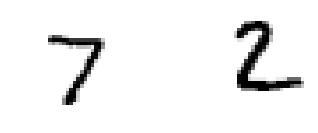

In [59]:
for i, image in enumerate([x_test[0], x_test[1]]):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

Your input node expects to get data with the shape (28,28,1) so you need to reshape your two digits.

In [60]:
image_1 = np.expand_dims(x_test[0], axis=2)
image_2 = np.expand_dims(x_test[1], axis=2)

Prepare the scoring payload and score.

In [61]:
scoring_data = {'values': [image_1.tolist(), image_2.tolist()]}

In [62]:
predictions = client.deployments.score(scoring_url, scoring_data)
print("Scoring result: " + str(predictions))

Scoring result: {'values': [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], 7, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]], [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 2, [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]], 'fields': ['prediction', 'prediction_classes', 'probability']}


<a id="summary"></a>
## 7. Summary and next steps     

You successfully completed this notebook! 
 
You learned how to use `watson-machine-learning-client` to train and score Keras models. 
 
Check out our <a href="https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html" target="_blank" rel="noopener noreferrer">Online Documentation</a> for more samples, tutorials, documentation, how-tos, and blog posts. 

### Citation
Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based learning applied to document recognition." Proceedings of the IEEE, 86(11):2278-2324, November 1998.

### Authors

**Lukasz Cmielowski**, PhD, is an Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.

Copyright © 2017, 2018 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>